### Trying to create 3 parallel autoencoder networks for 3 axis IMU data

In [58]:
%matplotlib inline
import pandas as pd
import datetime
# import pandas_datareader.data as web
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
print(torch.__version__)

1.0.1.post2


In [59]:
reqd_len = 150
channels = 1
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' : 
            self.df = pd.read_csv('../data/train.csv', header = None)
        elif mode == 'test' : 
            self.df = pd.read_csv('../data/test.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x = self.df.iloc[idx : idx + reqd_len, 0].values
        y = self.df.iloc[idx : idx + reqd_len, 1].values
        z = self.df.iloc[idx : idx + reqd_len, 2].values
        x = x.astype('float')
        y = y.astype('float')
        z = z.astype('float')
        assert(x.shape == (reqd_len, ))
        assert(x.shape == (reqd_len, ))
        assert(x.shape == (reqd_len, ))
        return x, y, z
        
train_dataset = IMUDataset(mode = 'train')
test_dataset = IMUDataset(mode = 'test')

(128100, 8)
(16200, 8)


In [60]:
batch_size = 16
train_indices = [(i * reqd_len) for i in range(len(train_dataset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(test_dataset) // reqd_len)]

trainloader = DataLoader(train_dataset, batch_size = batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
trainloader2 = DataLoader(train_dataset, batch_size = 1, sampler = SubsetRandomSampler(train_indices), drop_last = True)
testloader2 = DataLoader(test_dataset, batch_size = 1, sampler = SubsetRandomSampler(test_indices), drop_last = True)

In [61]:
# x2, y2, z2 = next(iter(trainloader2))
# print(x2.shape)
# signal = signal.detach().numpy()
# signal = np.transpose(signal).reshape(-1)
# t = range(150)
# plt.plot(t, signal[150 : 300])

In [62]:
# for xavier initialization of network
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class AutoEncoder(nn.Module) :
    def __init__(self) : 
        super(AutoEncoder, self).__init__()
        # defining layers
        self.encoder0 = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 5),
            nn.Tanh(),
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 5),
            nn.Tanh()
        )
        self.decoder0 = nn.Sequential(
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 5),
            nn.Tanh(),
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 5)
        )
        self.encoder1 = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 5),
            nn.Tanh(),
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 5),
            nn.Tanh()
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 5),
            nn.Tanh(),
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 5)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 5),
            nn.Tanh(),
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 5),
            nn.Tanh()
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 5),
            nn.Tanh(),
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 5)
        )
        self.classifier0 = nn.Sequential(
            nn.Linear(142, 128),
            nn.ReLU(),
            nn.Linear(128, 5),
            nn.LogSoftmax(dim = 1)
        )
        self.classifier1 = nn.Sequential(
            nn.Linear(142, 128),
            nn.ReLU(),
            nn.Linear(128, 5),
            nn.LogSoftmax(dim = 1)
        )
        self.classifier2 = nn.Sequential(
            nn.Linear(142, 128),
            nn.ReLU(),
            nn.Linear(128, 5),
            nn.LogSoftmax(dim = 1)
        )
        
    def forward(self, x, y, z, encode = False, classify = False) :
        features0 = self.encoder0(x)
        features1 = self.encoder1(y)
        features2 = self.encoder2(z)
        
        if encode and not classify:
            return features0, features1, features2
        elif not encode and classify :
#             features = torch.cat((features0, features1, features2), dim = 2)
            features0 = features0.view(batch_size, -1)
            features1 = features1.view(batch_size, -1)
            features2 = features2.view(batch_size, -1)
            return self.classifier0(features0), self.classifier1(features1), self.classifier2(features2)
        else : 
            return self.decoder0(features0), self.decoder1(features1), self.decoder2(features2)

In [63]:
Net = AutoEncoder()
Net.apply(init_weights)
if torch.cuda.is_available() : 
    Net = Net.cuda()
    print('Model on GPU')

Model on GPU


In [64]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(Net.parameters(), lr = 5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

In [65]:
num_epochs = 60
total_step = len(train_dataset) // (batch_size * 150)
train_loss_list = list()
min_loss = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (x, y, z) in enumerate(trainloader) :
        if torch.cuda.is_available():
            x = Variable(x).cuda().float()
            y = Variable(y).cuda().float()
            z = Variable(z).cuda().float()
        else : 
            x = Variable(x).float()
            y = Variable(y).float()
            z = Variable(z).float()
        
        x = x.reshape(-1, 1, 150)
        y = y.reshape(-1, 1, 150)
        z = z.reshape(-1, 1, 150)
        
        x_, y_, z_ = Net.forward(x, y, z)
        
        loss0 = criterion(x_, x)
        loss1 = criterion(y_, y)
        loss2 = criterion(z_, z)
        loss = loss0 + loss1 + loss2
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    if train_loss < min_loss : 
        min_loss = train_loss
        torch.save(Net.state_dict() , '../saved_models/autoencoder8.pt')
        print('Saving model', min_loss)
    
    scheduler.step()

epoch =  0  step =  0  of total steps  53  loss =  0.19983457028865814
epoch =  0  step =  20  of total steps  53  loss =  0.17277541756629944
epoch =  0  step =  40  of total steps  53  loss =  0.14121174812316895
Saving model 0.15900418190461285
epoch =  1  step =  0  of total steps  53  loss =  0.12326590716838837
epoch =  1  step =  20  of total steps  53  loss =  0.11895826458930969
epoch =  1  step =  40  of total steps  53  loss =  0.07502131164073944
Saving model 0.09543613449863668
epoch =  2  step =  0  of total steps  53  loss =  0.05707740783691406
epoch =  2  step =  20  of total steps  53  loss =  0.07730738818645477
epoch =  2  step =  40  of total steps  53  loss =  0.06798902153968811
Saving model 0.06657682485737891
epoch =  3  step =  0  of total steps  53  loss =  0.07563699781894684
epoch =  3  step =  20  of total steps  53  loss =  0.05895208567380905
epoch =  3  step =  40  of total steps  53  loss =  0.04900827258825302
Saving model 0.05420176677827565
epoch = 

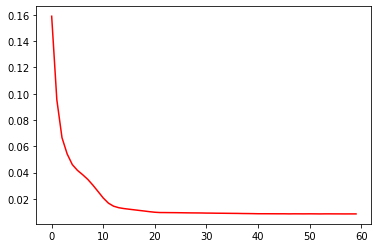

In [66]:
j = range(60)
plt.plot(j, train_loss_list, 'r')

### Verifying that AutoEncoder has not learnt the identity function

In [81]:
Net = AutoEncoder()
Net.load_state_dict(torch.load('../saved_models/autoencoder8.pt'))
Net = Net.eval()
print(Net.encoder0[0].weight)
print(Net.encoder0[2].weight)
print(Net.decoder0[0].weight)
print(Net.decoder0[2].weight)
print(Net.encoder1[0].weight)
print(Net.encoder1[2].weight)
print(Net.decoder1[0].weight)
print(Net.decoder1[2].weight)
print(Net.encoder2[0].weight)
print(Net.encoder2[2].weight)
print(Net.decoder2[0].weight)
print(Net.decoder2[2].weight)

Parameter containing:
tensor([[[ 0.5431,  0.1186, -0.0781,  0.4877, -0.0962]]], requires_grad=True)
Parameter containing:
tensor([[[-0.4119,  0.1509, -0.0806, -0.4062, -0.2905]]], requires_grad=True)
Parameter containing:
tensor([[[-0.3182,  0.1884, -0.3356, -0.2444, -0.4905]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.4077,  0.3128,  0.4128,  0.1809, -0.3030]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.1203, -0.6765, -0.1634,  0.0793, -0.1910]]], requires_grad=True)
Parameter containing:
tensor([[[-0.0951, -0.3740, -0.6052, -0.0522,  0.2104]]], requires_grad=True)
Parameter containing:
tensor([[[0.0121, 0.2386, 0.6408, 0.6618, 0.0936]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.5500,  0.1832,  0.1380,  0.1767, -0.1570]]], requires_grad=True)
Parameter containing:
tensor([[[-0.7863, -0.0027, -0.7519, -0.0771,  0.1519]]], requires_grad=True)
Parameter containing:
tensor([[[-0.3995, -0.1015, -0.7036, -0.4166,  0.0640]]], requires_grad=True)
Param

### Checking reconstruction quality visually

0.0072321295738220215


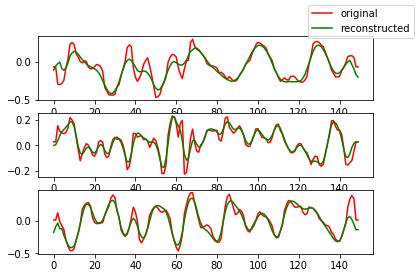

In [68]:
Net = Net.eval()
x, y, z = next(iter(trainloader))
x = x.reshape(-1, 1, 150).float()
y = y.reshape(-1, 1, 150).float()
z = z.reshape(-1, 1, 150).float()
x_, y_, z_ = Net.forward(x.float(), y.float(), z.float())
loss0 = criterion(x_, x)
loss1 = criterion(y_, y)
loss2 = criterion(z_, z)
print((loss0 + loss1 + loss2).item())

x = x.detach().numpy()
y = y.detach().numpy()
z = z.detach().numpy()
x_ = x_.detach().numpy()
y_ = y_.detach().numpy()
z_ = z_.detach().numpy()

fig, ax = plt.subplots(3, 1)
ax[0].plot(x[0][0], 'r', label = 'original')
ax[0].plot(x_[0][0], 'g', label = 'reconstructed')
ax[1].plot(y[0][0], 'r')
ax[1].plot(y_[0][0], 'g')
ax[2].plot(z[0][0], 'r')
ax[2].plot(z_[0][0], 'g')
fig.legend()

Reconstruction quality is very much improved compared to using 3 channel autoencoder or using 1 channel data for training autoencoder. Now we can try to train a classifier based on this.

In [69]:
reqd_len = 150
channels = 3
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' :
            self.df = pd.read_csv('../data/train.csv', header = None)
        elif mode == 'test' :
            self.df = pd.read_csv('../data/test.csv', header = None)
        elif mode == 'val' :
            self.df = pd.read_csv('../data/val.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        lab = self.df.iloc[idx : idx + reqd_len, 3 : ].values
        ind = np.argmax(np.sum(lab, axis = 0))
        label = np.zeros_like(self.df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        x = self.df.iloc[idx : idx + reqd_len, 0].values
        y = self.df.iloc[idx : idx + reqd_len, 1].values
        z = self.df.iloc[idx : idx + reqd_len, 2].values
        x = x.astype('float')
        y = y.astype('float')
        z = z.astype('float')
        assert(x.shape == (reqd_len, ))
        assert(y.shape == (reqd_len, ))
        assert(z.shape == (reqd_len, ))
        assert(label.shape == (5, ))
        return x, y, z, label
        
trainset = IMUDataset(mode = 'train')
valset = IMUDataset(mode = 'val')
testset = IMUDataset(mode = 'test')

(128100, 8)
(15900, 8)
(16200, 8)


In [70]:
train_batch_size = 16
batch_size = 16
train_indices = [(i * reqd_len) for i in range(len(trainset) // reqd_len)]
val_indices = [(i * reqd_len) for i in range(len(valset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(testset) // reqd_len)]

trainloader = DataLoader(trainset, batch_size = train_batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
valloader = DataLoader(valset, batch_size = batch_size, sampler = SubsetRandomSampler(val_indices), drop_last = True)
testloader = DataLoader(testset, batch_size = batch_size, sampler = SubsetRandomSampler(test_indices), drop_last = True)

In [90]:
# Loading autoencoder saved model
Net = AutoEncoder()
Net.load_state_dict(torch.load('../saved_models/autoencoder8.pt'), strict = False)
# freezing encoders' and decoders' layers
Net = Net.cuda()

for param in Net.encoder0.parameters() : 
    param.requires_grad = False
for param in Net.encoder1.parameters() : 
    param.requires_grad = False
for param in Net.encoder2.parameters() : 
    param.requires_grad = False
for param in Net.decoder0.parameters() : 
    param.requires_grad = False
for param in Net.decoder1.parameters() : 
    param.requires_grad = False
for param in Net.decoder2.parameters() : 
    param.requires_grad = False

In [91]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

In [92]:
num_epochs = 30
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (x, y, z, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            x = Variable(x).cuda().float()
            y = Variable(y).cuda().float()
            z = Variable(z).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            x = Variable(x).float()
            y = Variable(y).float()
            z = Variable(z).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)
        
        x = x.reshape(-1, 1, 150)
        y = y.reshape(-1, 1, 150)
        z = z.reshape(-1, 1, 150)
        
        x_pred, y_pred, z_pred = Net.forward(x, y, z, classify = True)
        
        outputs = (x_pred + y_pred + z_pred) / 3
        
        loss = criterion(outputs, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (x, y, z, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                x = Variable(x).cuda().float()
                y = Variable(y).cuda().float()
                z = Variable(z).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                x = Variable(x).float()
                y = Variable(y).float()
                z = Variable(z).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)
            
            x = x.reshape(-1, 1, 150)
            y = y.reshape(-1, 1, 150)
            z = z.reshape(-1, 1, 150)
            
            # Forward pass
            x_pred, y_pred, z_pred = Net.forward(x, y, z, classify = True)
            
            outputs = (x_pred + y_pred + z_pred) / 3
            
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '../saved_models/autoencoder_classifier3.pt')
    
    scheduler.step()

epoch =  0  step =  0  of total steps  53  loss =  1.6802492141723633
epoch =  0  step =  20  of total steps  53  loss =  1.5880217552185059
epoch =  0  step =  40  of total steps  53  loss =  1.5610613822937012
epoch :  0  /  30  | TL :  1.570339708958032  | VL :  1.5760257244110107
saving model
epoch =  1  step =  0  of total steps  53  loss =  1.4960960149765015
epoch =  1  step =  20  of total steps  53  loss =  1.527087926864624
epoch =  1  step =  40  of total steps  53  loss =  1.4667404890060425
epoch :  1  /  30  | TL :  1.4800380805753313  | VL :  1.5563395023345947
saving model
epoch =  2  step =  0  of total steps  53  loss =  1.4010610580444336
epoch =  2  step =  20  of total steps  53  loss =  1.5319502353668213
epoch =  2  step =  40  of total steps  53  loss =  1.4896175861358643
epoch :  2  /  30  | TL :  1.433875007449456  | VL :  1.5479378700256348
saving model
epoch =  3  step =  0  of total steps  53  loss =  1.4219242334365845
epoch =  3  step =  20  of total ste

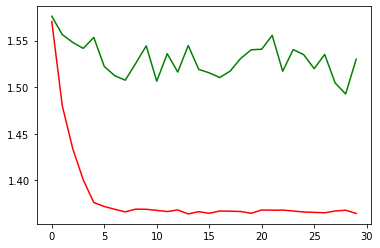

In [93]:
j = np.arange(30)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [94]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (x, y, z, labels) in enumerate(dataloader):
        x = Variable(x).float()
        y = Variable(y).float()
        z = Variable(z).float()
        labels = Variable(labels).float()
        x = x.reshape(-1, 1, 150)
        y = y.reshape(-1, 1, 150)
        z = z.reshape(-1, 1, 150)
        x_pred, y_pred, z_pred = Net(x, y, z, classify = True)
        outputs = (x_pred + y_pred + z_pred) / 3
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.cpu().eval()
# _get_accuracy(trainloader)

In [95]:
print(_get_accuracy(trainloader, Net))
print(_get_accuracy(testloader, Net))
print(_get_accuracy(valloader, Net))

0.41037735849056606
0.3229166666666667
0.3333333333333333


#### Verifying that encoder and decoder weights remained frozen

In [96]:
print(Net.encoder0[0].weight)
print(Net.encoder0[2].weight)
print(Net.decoder0[0].weight)
print(Net.decoder0[2].weight)
print(Net.encoder1[0].weight)
print(Net.encoder1[2].weight)
print(Net.decoder1[0].weight)
print(Net.decoder1[2].weight)
print(Net.encoder2[0].weight)
print(Net.encoder2[2].weight)
print(Net.decoder2[0].weight)
print(Net.decoder2[2].weight)

Parameter containing:
tensor([[[ 0.5431,  0.1186, -0.0781,  0.4877, -0.0962]]])
Parameter containing:
tensor([[[-0.4119,  0.1509, -0.0806, -0.4062, -0.2905]]])
Parameter containing:
tensor([[[-0.3182,  0.1884, -0.3356, -0.2444, -0.4905]]])
Parameter containing:
tensor([[[ 0.4077,  0.3128,  0.4128,  0.1809, -0.3030]]])
Parameter containing:
tensor([[[ 0.1203, -0.6765, -0.1634,  0.0793, -0.1910]]])
Parameter containing:
tensor([[[-0.0951, -0.3740, -0.6052, -0.0522,  0.2104]]])
Parameter containing:
tensor([[[0.0121, 0.2386, 0.6408, 0.6618, 0.0936]]])
Parameter containing:
tensor([[[ 0.5500,  0.1832,  0.1380,  0.1767, -0.1570]]])
Parameter containing:
tensor([[[-0.7863, -0.0027, -0.7519, -0.0771,  0.1519]]])
Parameter containing:
tensor([[[-0.3995, -0.1015, -0.7036, -0.4166,  0.0640]]])
Parameter containing:
tensor([[[ 0.1390,  0.1768,  0.3902,  0.0566, -0.2365]]])
Parameter containing:
tensor([[[ 0.1733,  0.4196,  0.3301, -0.1437,  0.3934]]])
